In [1]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [2]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import weight_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         weight_norm(nn.Conv1d(1, 32, 3, padding=1)),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         weight_norm(nn.Conv1d(32, 32, 3, padding=1)),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         weight_norm(nn.Conv1d(32, 32, 3, padding=1)),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=20, num_hidden=500, num_layers=1, sequence_length=17, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [3]:
ticker_data_file = 'data/ticker_data.xlsx'
ticker_data = pd.read_excel(ticker_data_file)
tickers = ticker_data['Symbol'].to_list()
tickers_str = ''
for ticker in tickers:
    #delisted
    if (ticker != 'BRK.B'):
        tickers_str = tickers_str + ticker + ' '
tickers_str = tickers_str[:len(tickers_str)-1]
tickers.remove('BRK.B')

In [4]:
price_data = yf.download( 
        tickers = tickers_str,
        start="2018-01-01", end="2020-12-31",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None)

[*********************100%***********************]  49 of 49 completed


In [5]:
price_df = pd.DataFrame({})
for tick in tickers:
    df = price_data[tick]['Open']
    price_df[tick] = df

In [6]:
#inspect na, remove paypal
price_df.isnull().sum()
price_df = price_df.drop (['PYPL'],axis=1)

In [7]:
#technical indicators
factor_list = ['macd', 'mom', 'rsi', 'slope', 'stoch', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'bbands', 'adx', 'entropy', 'stochrsi']

In [8]:
#technical indicators
factor_data = {}
for factor_name in factor_list:
    try:
        factor_df = pd.DataFrame({})
        shift = True
        for tick in price_df.columns:
            ta_df = price_data[tick]
            factor_df[tick] = getattr(ta_df.copy().ta, factor_name)()
        factor_df = factor_df.shift(int(shift))
        factor_data[factor_name] = factor_df
    except:
        continue

In [9]:
#remaining factors
print (factor_data.keys())

dict_keys(['mom', 'rsi', 'slope', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'entropy'])


In [10]:
#fourier transform
fourier_df = pd.DataFrame({}, index = price_data.index)
for tick in price_df.columns:
    df = price_data[tick]['Close']
    
    fourier_df[tick] = np.fft.fft(np.asarray(df.tolist()))
# factor_df = factor_df.stack()
# factor_df.index = factor_df.index.set_names(['date', 'asset'])

In [11]:
for tick in price_df.columns:
    fft_list = fourier_df[tick]
    num = 3
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num:-num]=0
    ifft = np.fft.ifft(fft_list_m10)
    fourier_df[tick] = ifft

In [12]:
#create data to use 
data_final = pd.DataFrame(index = price_df.index)
data_final['AAPL'] = price_df['AAPL']
for i, ticker in enumerate(price_df.columns):
    if (i < 10):
        data_final[ticker] = price_df[ticker]
        
data_final['Fourier'] = fourier_df['AAPL']
for factor in factor_data.keys():
    data_final[factor] = factor_data[factor]['AAPL']
data_final = data_final.dropna(how = 'any', axis = 0)




In [13]:
#turn data into their format
data_final_list = []
example_size = 18
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

/Users/Nick/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [14]:
len(data_final_list)

707

In [15]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [16]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [17]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['AAPL'][data_size:]]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)
        generated_data = torch.unsqueeze(torch.squeeze(generated_data, 2).permute(1,0)[:,16], 1)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.unsqueeze(torch.squeeze(generator_result, 2).permute(1,0)[:,16], 1)
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:17, :, :]
                    true_val = data[17, :, 0]
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)[:,16]
                    returns_generated.append(generator_result.detach().numpy()[0])
                    returns_true.append(true_val.numpy()[0])
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 5000
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns

Training is about to start...


  0%|          | 0/5000 [00:00<?, ?it/s]

MAE
110.25365625479526



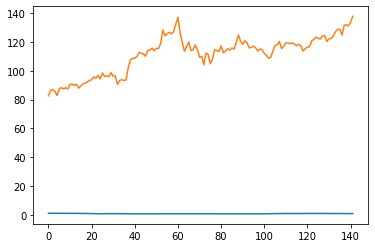

  1%|          | 50/5000 [12:33<22:09:23, 16.11s/it]

MAE
105.2223657425256



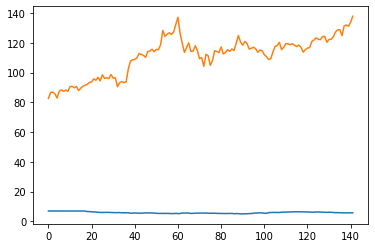

  2%|▏         | 100/5000 [26:31<22:13:43, 16.33s/it]

MAE
102.8361231715142



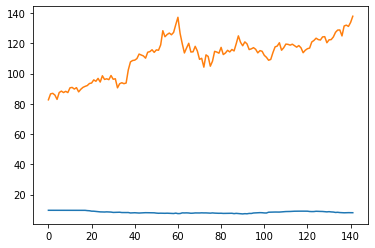

  3%|▎         | 150/5000 [39:58<22:52:17, 16.98s/it]

MAE
100.48523289101898



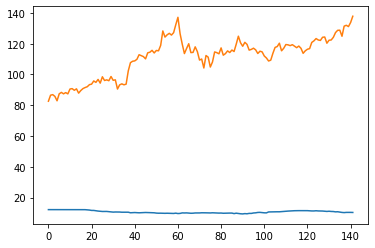

  4%|▍         | 200/5000 [54:56<22:57:50, 17.22s/it]

MAE
97.94891732228308



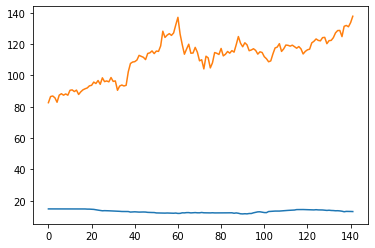

  5%|▌         | 250/5000 [1:10:06<24:25:47, 18.52s/it]

MAE
95.50445942864286



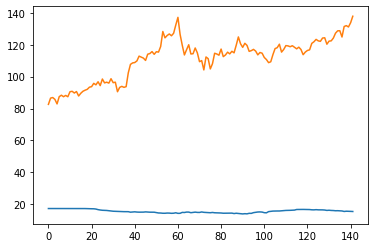

  6%|▌         | 300/5000 [1:25:39<24:46:23, 18.98s/it]

MAE
93.08660644933205



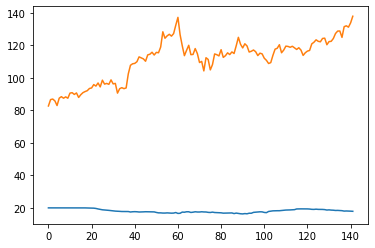

  7%|▋         | 350/5000 [1:39:59<20:09:58, 15.61s/it]

MAE
90.65716189450615



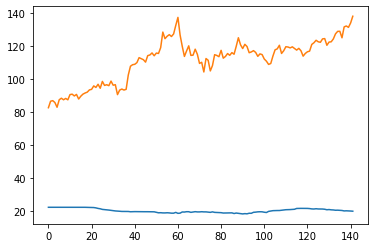

  8%|▊         | 400/5000 [1:53:11<21:05:02, 16.50s/it]

MAE
88.13503493106535



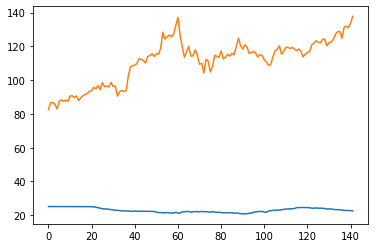

  9%|▉         | 450/5000 [2:07:09<20:54:00, 16.54s/it]

MAE
85.24603501896458



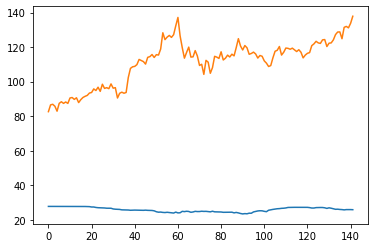

 10%|█         | 500/5000 [2:21:09<21:00:04, 16.80s/it]

MAE
82.74900055655965



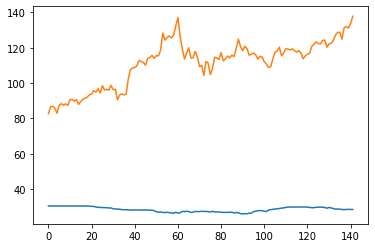

 11%|█         | 550/5000 [2:35:24<21:48:55, 17.65s/it]

MAE
80.25753188521763



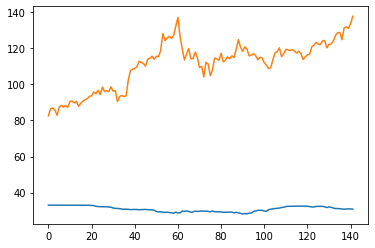

 12%|█▏        | 600/5000 [2:50:33<21:58:17, 17.98s/it]

MAE
77.80404142647396



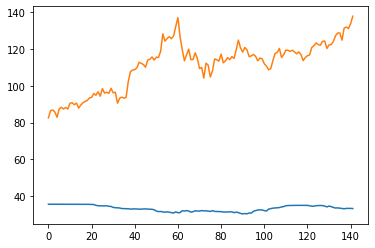

 13%|█▎        | 650/5000 [3:05:15<21:17:52, 17.63s/it]

MAE
75.36508892676194



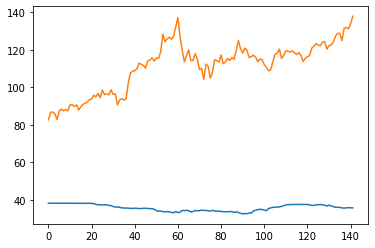

 14%|█▍        | 700/5000 [3:20:04<20:42:47, 17.34s/it]

MAE
72.92928993250956



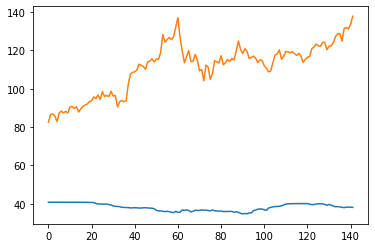

 15%|█▌        | 750/5000 [3:34:17<20:08:45, 17.06s/it]

MAE
70.49183587006114



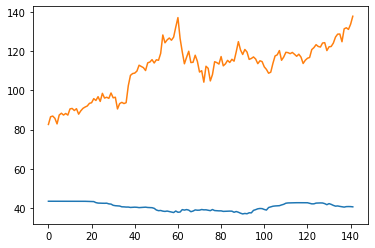

 16%|█▌        | 800/5000 [3:48:47<19:17:29, 16.54s/it]

MAE
68.05901365601514



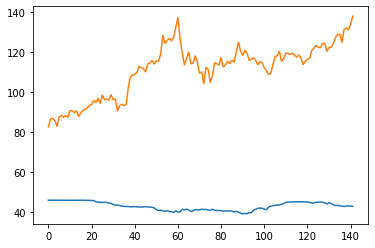

 17%|█▋        | 850/5000 [4:02:41<18:52:14, 16.37s/it]

MAE
65.20087018535844



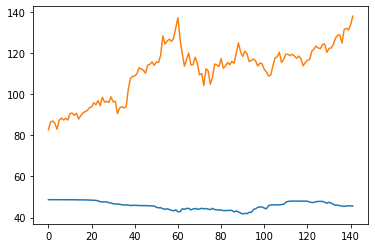

 18%|█▊        | 900/5000 [4:16:39<18:48:46, 16.52s/it]

MAE
62.75527448438257



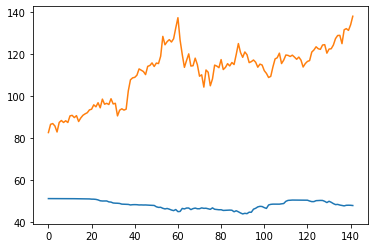

 19%|█▉        | 950/5000 [4:30:36<18:38:55, 16.58s/it]

MAE
60.31878779692383



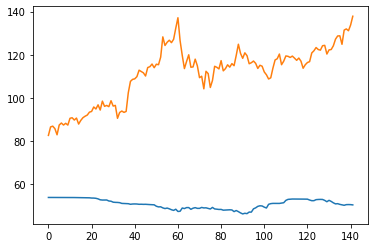

 20%|██        | 1000/5000 [4:45:00<18:55:09, 17.03s/it]

MAE
57.89240720962808



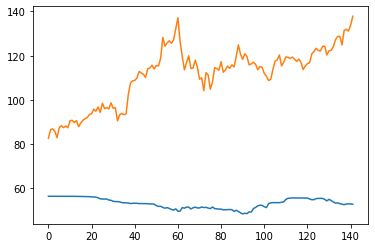

 21%|██        | 1050/5000 [4:59:01<18:03:34, 16.46s/it]

MAE
55.478780713407104



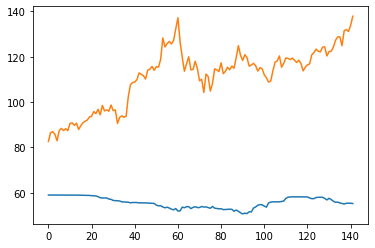

 22%|██▏       | 1100/5000 [5:12:53<17:56:02, 16.55s/it]

MAE
53.082297117465



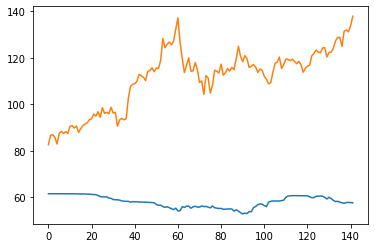

 23%|██▎       | 1150/5000 [5:27:04<17:29:50, 16.36s/it]

MAE
50.70873450614031



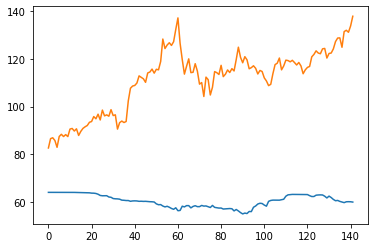

 24%|██▍       | 1200/5000 [5:41:11<17:20:32, 16.43s/it]

MAE
48.3673312971525



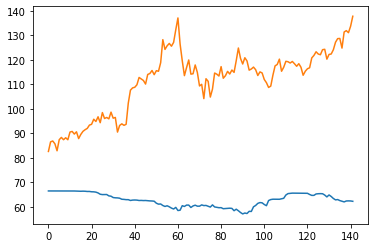

 25%|██▌       | 1250/5000 [5:54:34<16:21:36, 15.71s/it]

MAE
46.07532014362243



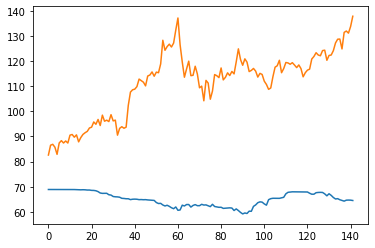

 26%|██▌       | 1300/5000 [6:07:38<16:04:51, 15.65s/it]

MAE
43.86666772787674



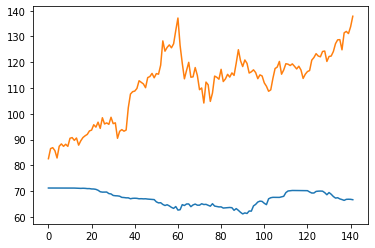

 27%|██▋       | 1350/5000 [6:20:48<16:18:41, 16.09s/it]

MAE
41.81781668782907



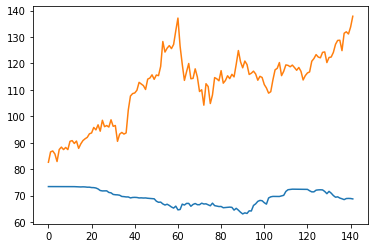

 28%|██▊       | 1400/5000 [6:34:15<15:33:26, 15.56s/it]

MAE
40.125776768257936



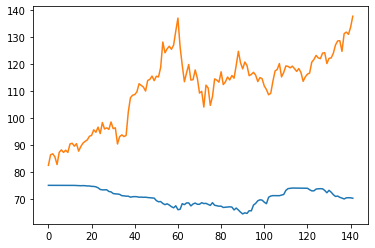

 29%|██▉       | 1450/5000 [6:47:13<15:17:08, 15.50s/it]

MAE
39.3596281876262



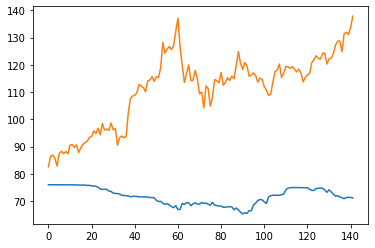

 30%|███       | 1500/5000 [7:00:16<15:06:33, 15.54s/it]

MAE
43.778276920845826



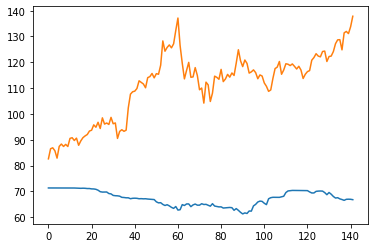

 31%|███       | 1550/5000 [7:13:22<14:59:44, 15.65s/it]

MAE
46.2704952876568



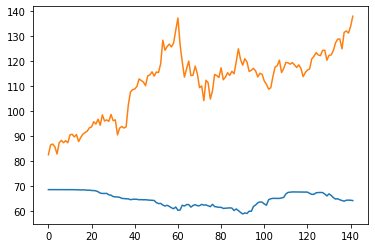

 32%|███▏      | 1600/5000 [7:26:38<14:49:46, 15.70s/it]

MAE
48.73207658498054



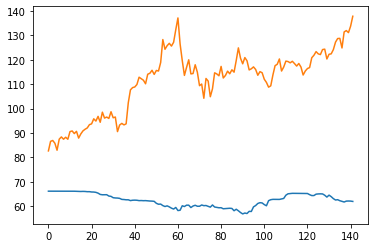

 33%|███▎      | 1650/5000 [7:39:47<14:33:51, 15.65s/it]

MAE
51.18850196971694



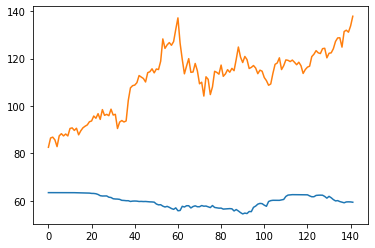

 34%|███▍      | 1700/5000 [7:52:55<14:14:38, 15.54s/it]

MAE
53.63974452407261



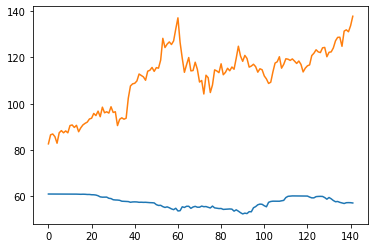

 35%|███▌      | 1750/5000 [8:06:02<14:07:41, 15.65s/it]

MAE
56.08484181604589



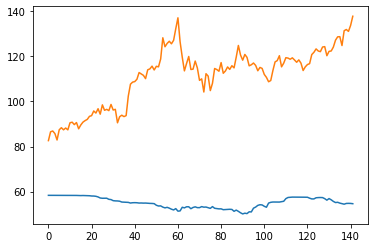

 36%|███▌      | 1800/5000 [8:19:34<14:21:44, 16.16s/it]

MAE
58.52248615666848



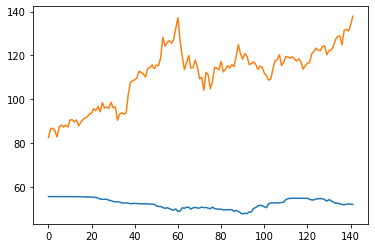

 37%|███▋      | 1850/5000 [8:33:05<14:22:55, 16.44s/it]

MAE
60.950832521938956



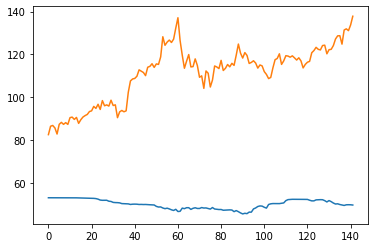

 38%|███▊      | 1900/5000 [8:46:43<13:49:18, 16.05s/it]

MAE
63.367735144645415



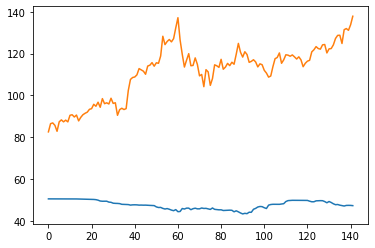

 39%|███▉      | 1950/5000 [8:59:49<13:06:30, 15.47s/it]

MAE
65.7695036544162



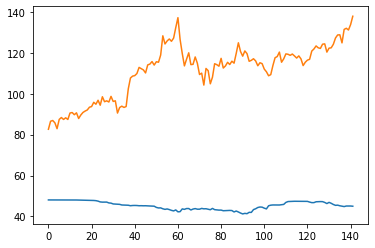

 40%|████      | 2000/5000 [9:12:05<11:50:52, 14.22s/it]

MAE
68.15091978716852



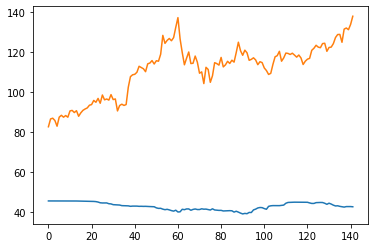

 41%|████      | 2050/5000 [9:23:52<11:35:56, 14.15s/it]

MAE
70.50365632741217



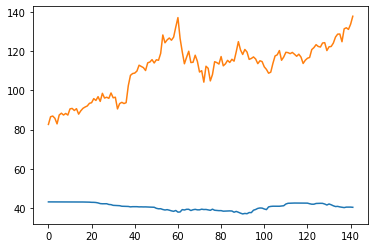

 42%|████▏     | 2100/5000 [9:35:42<11:15:32, 13.98s/it]

MAE
72.81307332669179



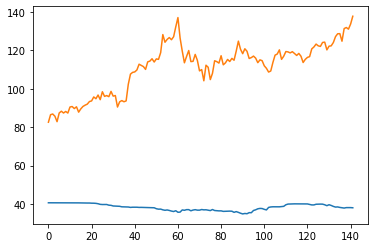

 43%|████▎     | 2150/5000 [9:47:26<11:01:42, 13.93s/it]

MAE
75.05116104796572



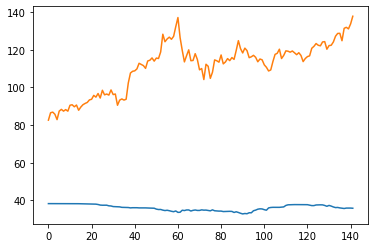

 44%|████▍     | 2200/5000 [9:59:14<10:54:57, 14.03s/it]

MAE
77.15733136646179



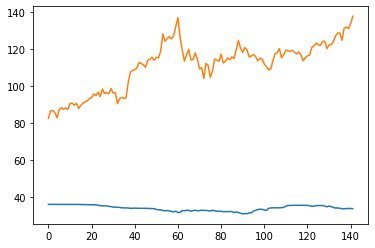

 45%|████▌     | 2250/5000 [10:10:57<10:42:44, 14.02s/it]

MAE
78.94723498034479



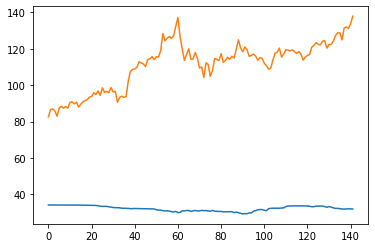

 46%|████▌     | 2300/5000 [10:24:13<11:46:20, 15.70s/it]

MAE
77.74923649021271



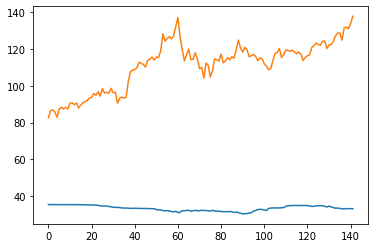

 47%|████▋     | 2350/5000 [10:36:40<10:22:29, 14.09s/it]

MAE
74.74691653640171



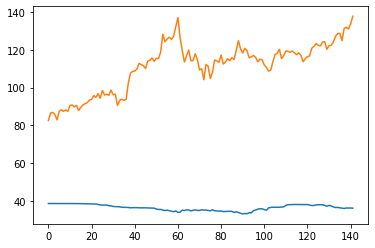

 48%|████▊     | 2400/5000 [10:50:12<12:29:49, 17.30s/it]

MAE
72.27463837125606



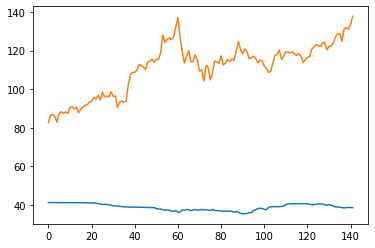

 49%|████▉     | 2450/5000 [11:04:07<11:07:09, 15.70s/it]

MAE
69.81526876556036



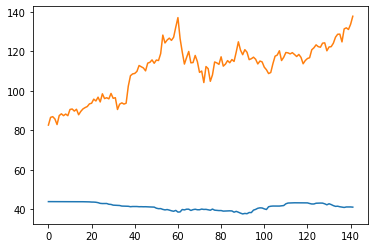

 50%|█████     | 2500/5000 [11:18:05<12:02:56, 17.35s/it]

MAE
67.36090420386155



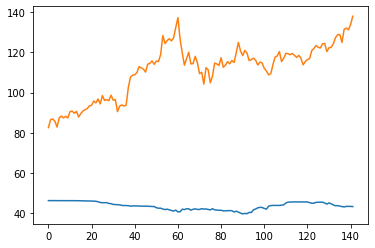

 51%|█████     | 2550/5000 [11:32:16<10:51:46, 15.96s/it]

MAE
64.91208535233687



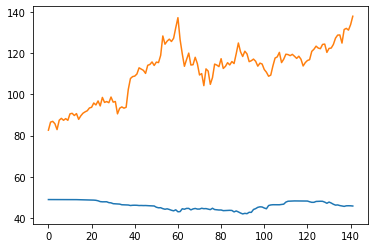

 52%|█████▏    | 2600/5000 [11:46:32<12:38:05, 18.95s/it]

MAE
62.46995847378652



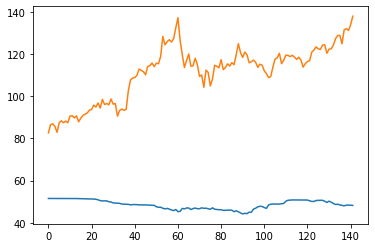

 53%|█████▎    | 2650/5000 [12:04:04<14:32:17, 22.27s/it]

MAE
60.03600087688676



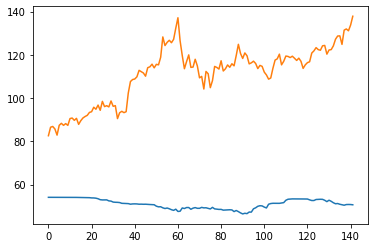

 54%|█████▍    | 2700/5000 [12:21:04<12:48:14, 20.04s/it]

MAE
57.61222000577754



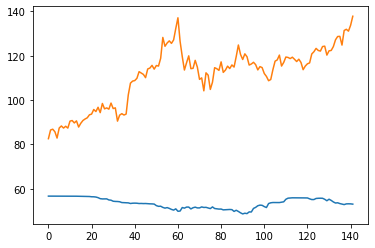

 55%|█████▌    | 2750/5000 [12:36:50<11:25:45, 18.29s/it]

MAE
55.20140230876293



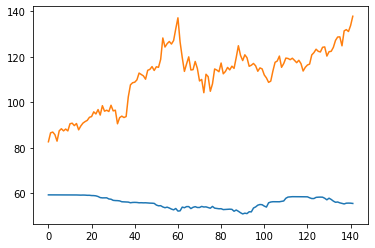

 56%|█████▌    | 2783/5000 [12:46:40<9:53:57, 16.07s/it] 

KeyboardInterrupt: 

In [18]:
returns = run_GAN()

In [ ]:
returns_generated = returns[0]
returns_true = returns[1]

In [ ]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [605]:
#MAE
mean_absolute_error(returns_generated, returns_true)

18.175057003698715

In [606]:
#calculate generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( (returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( (returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [607]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i])
    else:
        strategy_returns.append(0)

1.9137289319462578
1.4325411274753184
0.00010692395144771673
0.20345949183619325
0.15071056330039215
-0.09023120905347894
0.30962343096234307


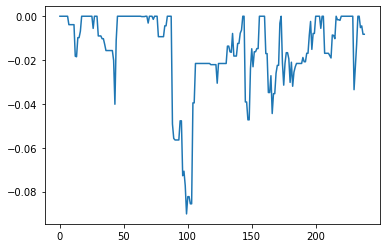

In [615]:
#eval strategy returns

#cumualtive reeturns real
cum_returns_real = 1
cum_ret_real = []
for i in range (len(returns_percent_true)):
    cum_returns_real  = cum_returns_real * (1 + returns_percent_true[i])
    cum_ret_real.append(cum_returns_real)
print (cum_returns_real)

#cumulative returns
cum_returns = 1
cum_ret = []
for i in range (len(strategy_returns)):
    cum_returns  = cum_returns * (1 + strategy_returns[i])
    cum_ret.append(cum_returns)
print (cum_returns)

#variance
variance = np.var(strategy_returns)
print (variance)

#sharpe real
std = np.std(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/std
print (sharpe)

#sharpe
std = np.std(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/std
print (sharpe)

#drawdown
previous_peaks = np.maximum.accumulate(cum_ret)
drawdown = (cum_ret-previous_peaks)/previous_peaks
max_drawdown = np.ndarray.min(drawdown)
print (max_drawdown)
plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

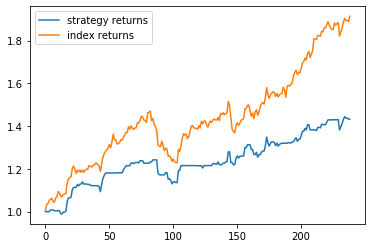

In [616]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [612]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



-96.55731129591832


In [618]:
np.var(strategy_returns)*100

0.010692395144771674

In [614]:
std

0.010340403833879833